In [1]:
%pylab inline
import numpy as np
import scipy as sc
import scipy.ndimage as ndi
import pylab as pl
import matplotlib as mpl
from IPython import display
from itertools import islice
rc("image", cmap="gray")

Populating the interactive namespace from numpy and matplotlib


# Tar Record Files

The default storage format for dlinputs is the tar files, with the convention that all files sharing a common basename make up a training sample. You can create these tar files using simple shell commands. You do need to ensure that files that belong together are adjacent in the tar file, but you can do that using by sorting. An easy way of creating a tar file is a command like:

    find . -print -name '*.png' -o -name '*.cls' | sort | tar -zcvf dataset.tgz -T -

In [2]:
!tar -ztvf testdata/sample.tgz | sed 5q

-rw-r--r-- tmb/tmb           1 1969-12-31 16:00 10.cls
-rw-r--r-- tmb/tmb         306 1969-12-31 16:00 10.png
-rw-r--r-- tmb/tmb           1 1969-12-31 16:00 11.cls
-rw-r--r-- tmb/tmb         345 1969-12-31 16:00 11.png
-rw-r--r-- tmb/tmb           1 1969-12-31 16:00 12.cls
tar: write error


Consecutive files with the same
basename are returned as items in a dictionary; the extension is used
as the key to each entry.

By default, files are decoded based on their file name extension, but you can supply a custom decoder with the `decode=` argument, or turn off decoding altogether with `decode=False`.

__key__ '10'
cls 0
png float32 (28, 28)


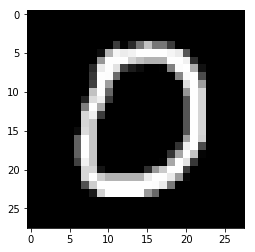

In [8]:
from dlinputs import tarrecords, utils
data = tarrecords.tariterator(open("testdata/sample.tgz"))
for sample in data:
    utils.print_sample(sample)
    imshow(sample["png"])
    break

Note that the `tariterator` operates over over any kind of stream, so you can open a URL. You can either use `urllib2` for that, or use `popen`:

    stream = os.popen("curl http://server/dataset")
    for sample in tarrecords.tariterator(stream):
        ...

The latter has the advantage that I/O and Python processing happen in separate threads.

In fact, the `gopen` submodule wraps up a bunch of ways of opening different locations, so you can use `gopen.open_source`.

__key__ '10'
cls 0
png float32 (28, 28)


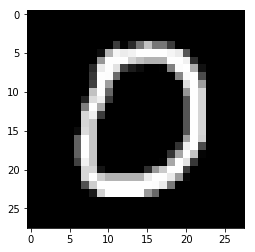

In [12]:
from dlinputs import gopen
for sample in gopen.open_source("testdata/sample.tgz"):
    utils.print_sample(sample)
    simsho
    break

Note, however, that in normal code, you probably shouldn't use either `tariterator` or `open_source` directly, since they don't handle sharding. The sharded I/O functions below (`sharditerator`, `sharditerator_once`) work for non-sharded files as well, so you can use them for everything.

# Sharded Files

For larger datasets, sharding is a good idea. Shards are simply a list of consecutively numbered file names. The usual notation within this library is to use a file name or URL with an embedded string preceded by an "@":

    http://server/data-@000123.tgz
    
This URL refers to 123 shards with names of `http://server/data-000000.tgz` to `http://server/data-000122.tgz`

In [16]:
from dlinputs import paths
list(paths.path_shards("dir/prefix-@0004.tgz"))

['dir/prefix-0000.tgz',
 'dir/prefix-0001.tgz',
 'dir/prefix-0002.tgz',
 'dir/prefix-0003.tgz']

trying: http://localhost:9501/imagenet.shards
# read_shards http://localhost:9501/imagenet.shards base http://localhost:9501/
# reading ['http://localhost:9501/imagenet-000000.tgz']
304


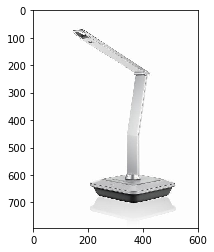

In [21]:
data = (dli.ittarshards("http://localhost:9501/imagenet.shards") |
        # dli.itinfo() |
        dli.itmap(png=dli.pilrgb, cls=int))
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

# reading ['http://localhost:9501/imagenet-000000.tgz']
304


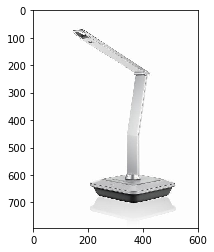

In [22]:
data = (dli.ittarshards("http://localhost:9501/imagenet-@000001.tgz") |
        # dli.itinfo() |
        dli.itmap(png=dli.pilrgb, cls=int))
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

To make input pipelines movable between different environments, you can also specify an `urlpath`, a list of URL roots to search (you can also supply these as a whitespace separated string).

trying: http://mars:9501/imagenet.shards
http://mars:9501/imagenet.shards : FAILED
trying: http://jupiter:9501/imagenet.shards
http://jupiter:9501/imagenet.shards : FAILED
trying: http://localhost:9501/imagenet.shards
# read_shards imagenet.shards base http://localhost:9501/
# reading ['http://localhost:9501/imagenet-000000.tgz']
304


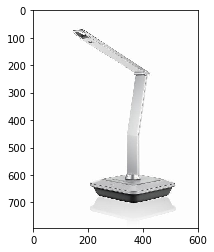

In [23]:
urlpath = """
http://mars:9501/
http://jupiter:9501/
http://localhost:9501/
""".strip().split()

data = (dli.ittarshards("imagenet.shards", urlpath=urlpath) | \
        dli.itmap(png=dli.pilrgb, cls=int))
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

# Other Input Filters

There are more pipeline components:

- `itshuffle` shuffles samples inline
- `itstandardize` performs image size standardization
- `itbatch` performs batching of inputs

More are being added to `dlpipes`, including in-memory and on-disk caching, more data augmentation, and distributed and parallel pipes.

(5, 256, 256, 3)
[551 304 180 165 625]


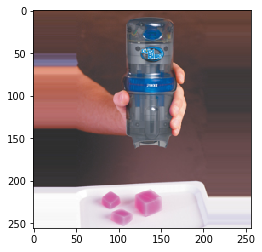

In [24]:
data = (dli.ittarreader("testdata/imagenet-000000.tgz") |
        dli.itshuffle(1000) |
        dli.itmap(png=dli.pilrgb, cls=int) |
        dli.itren(image="png", cls="cls") |
        dli.itstandardize((256,256)) |
        dli.itbatch(5))
for sample in data:
    print sample["image"].shape
    imshow(sample["image"][0])
    print sample["cls"]
    break

# Loadable Inputs and Models

In many applications, it's useful to separate the input pipelines and model definitions from the source code of the application. The `dlpipes.loadable` module addresses this problem. It allows input pipelines and models to be defined with arbitrary Python code, but to be imported by file name rather than using the `import` statement.

In [25]:
!cat input-sample.py

#!/usr/bin/python

import dlinputs as dli

class Inputs(object):
    def training_data(self, **kw):
        return dli.itsqlite("testdata/sample.db", **kw) | \
               dli.itmap(image=dli.pilgray, cls=int)


Note that loadable input pipelines can be written using arbitrary Python code; they simply need to return Python iterators.

Different partitions of the dataset may get different `*_data` methods. You generally should have at least `training_data` and `test_data`. All and only datasets should have methods ending in `_data`.

Loadable input pipelines and models written in Python must end in `.py`; that's because the loader will eventually also load JSON and YAML definitions of pipelines and models.

In [26]:
factory = dli.loadable.load_input("input-sample.py")
training_data = factory.training_data()
training_data.next().keys()

['image', 'inx', '__epoch__', 'cls']

Defining dataset iterators in this way allows us to create useful tools that operate over datasets. For example, `show-input` provides information about a dataset iterators; optionally, it can also benchmark. There are other tools for broadcasting datasets over the network, dumping them into sharded files, etc.

In [27]:
!./show-input input-sample.py

datasets: training
showing: training

      __epoch__ 0
            cls 6
          image (28, 28) [0.0,1.0] 0.12811124(0.3003297736710757)
            inx 999


# Parallelizing Input Pipelines

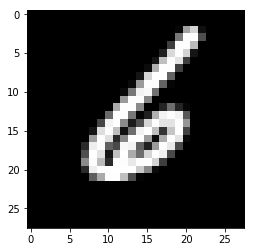

In [ ]:
def factory():
    return dli.itsqlite("testdata/sample.db") | \
           dli.itmap(image=dli.pilgray, cls=int)
data = factory()
imshow(data.next()["image"])

In [ ]:
data = dli.parallel.parallelize_input(factory, 4)
imshow(data.next()["image"])

Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-2:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
  File "dlinputs/parallel.py", line 10, in _parallel_job
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    data = factory(*args)
Process Process-3:
    self.run()
TypeError: factory() argument after * must be an iterable, not int
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "dlinputs/parallel.py", line 10, in _parallel_job
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    data = factory(*args)
    self.run()
TypeError: factory() argument after * must be an iterable, not int
  File "/usr/li